In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.stats import linregress as linreg

import pandas as pd

import pickle
import os.path

import warnings
warnings.simplefilter('ignore')

from rbf import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [288]:
matplotlib.rcParams.update({'font.size': 14})

In [289]:
xs = np.arange(30)
c = 15
k = 4
print(xs[c-k//2:c+(k+1)//2])

[13 14 15 16]


In [290]:
def fd_approx(xs, rbf_obj, epsilon=None, stencil_size=10, deg=-1, optimize_shape=False):
    rbf = rbf_obj['rbf']
    d2rbf = rbf_obj['d2rbf']
    n = len(xs)
    k = min(n, stencil_size)
    weights = np.zeros((n, k))
    row_index = [r for r in range(n) for c in range(stencil_size)]
    col_index = np.zeros((n, stencil_size))
    
    conds = []
    
    for i, center in enumerate(xs):
        if i < k//2:
            ids = np.arange(k)
        elif i+(k+1)//2 >= n:
            ids = np.arange(n-k, n)    
        else:
            ids = np.arange(i-k//2, i+(k+1)//2)
        col_index[i] = ids
        stencil = xs[ids] - center # shift
        scale_factor = np.max(np.abs(stencil))
        stencil = stencil / scale_factor # scale
        dist_mat = np.abs(np.subtract.outer(stencil, stencil))
        
        if deg>=0:
            P = np.power.outer(stencil, np.arange(deg+1))
        else:
            P = None
            
        if optimize_shape:
            #print('optimizing')
            epsilon = optimize_eps(rbf, dist_mat, P=None)
        
        A = rbf(dist_mat, epsilon)
        #print('cond test: %g' % np.log(la.cond(A)))
        if deg>=0:
            AP = np.block([[A, P],[P.T,np.zeros((deg+1, deg+1))]])
        else:
            AP = A
        
        #conds.append([la.cond(AP)])
        
        rhs_rbf = d2rbf(np.abs(stencil), epsilon)
        rhs_poly = np.zeros(deg+1)
        if deg>=2:
            rhs_poly[2] = 2
        rhs = np.block([rhs_rbf, rhs_poly])
        weights[i] = la.solve(AP, rhs)[:k]  / scale_factor**2

    W = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))
    return W #, conds
    

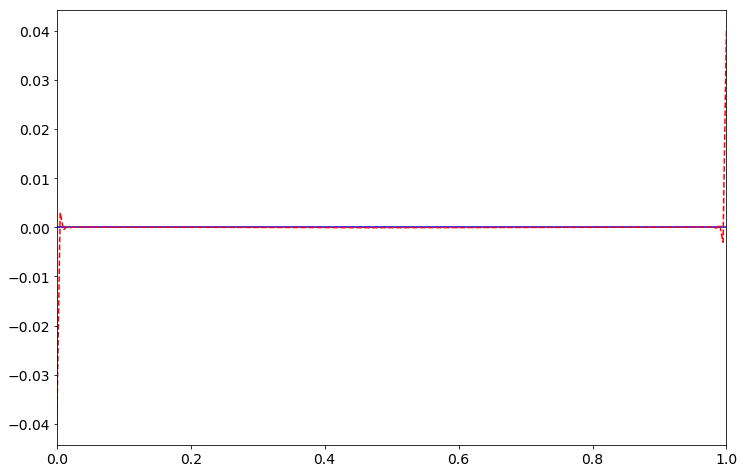

In [291]:
a, b = 0, 1
def foo(x):
    return np.sin(2*np.pi*x)

def d2foo(x):
    return -(2*np.pi)**2 * np.sin(2*np.pi*x)
#rbf_label = 'ninth degree PHS'
rbf_label = 'multiquadric'
n = 200
k = 10
eps = 20
deg = 2

rbf_obj = rbf_dict[rbf_label]
xs = np.linspace(a, b, n)
W = fd_approx(xs, rbf_obj, eps, stencil_size=k, deg=deg, 
                             optimize_shape=rbf_obj['shape'])
us = W @ foo(xs)

plt.figure(figsize=(12,8))
plt.plot(xs, np.zeros(len(xs)), 'b-')
plt.plot(xs, us-d2foo(xs), 'r--')
plt.xlim(a,b)
#plt.ylim(-1, 1)
plt.show()

In [222]:
rbf_label = 'gaussian'
n = 200
k = 10
degs = range(-1,5)
epsilons = [10 *.9**i for i in range(40)]

all_errors = [ [] for d in degs]

rbf_obj = rbf_dict[rbf_label]
xs = np.linspace(a, b, n)
Lfs = d2foo(xs)

for d_index, d in enumerate(degs):
    for eps in epsilons:
        W = fd_approx(xs, rbf_obj, eps, stencil_size=k, deg=d, optimize_shape=False)
        us = W @ foo(xs)
        err = la.norm(us - Lfs)/la.norm(Lfs)
        all_errors[d_index].append(err)

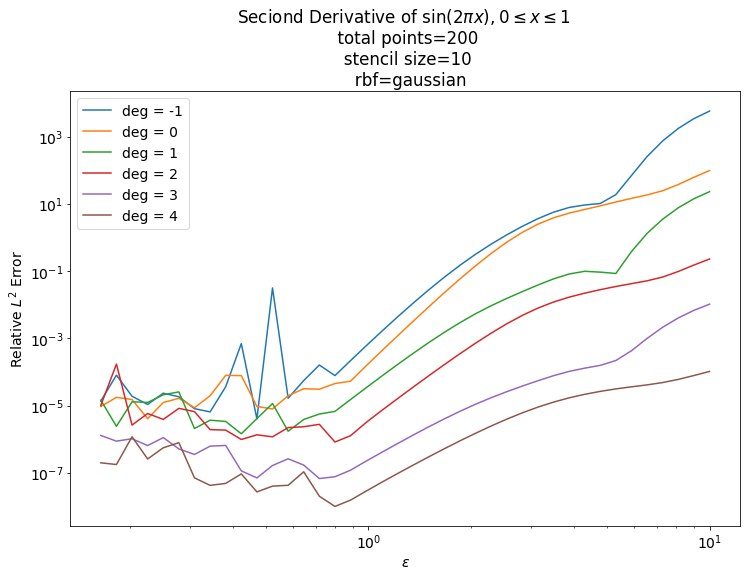

In [223]:
plt.figure(figsize=(12,8))
for d, errors in zip(degs, all_errors):
    plt.loglog(epsilons, errors)
plt.legend(['deg = %d' % d for d in degs])
plt.xlabel('$\\varepsilon$')
plt.ylabel('Relative $L^2$ Error')
plt.title('Seciond Derivative of $\\sin(2\\pi x), 0 \leq x \leq 1$ \n total points=%d\n  stencil size=%d \n  rbf=%s' % (n,k,rbf_label))
plt.show()

In [265]:
ns = [16 * 2**i for i in range(10)];   print('ns =', ns)
k = 10
degs = range(-1, 5)
rbf_label = 'cubic spline'


rbf_obj = rbf_dict[rbf_label]
rbf = rbf_obj['rbf']

# find epsilon on finest nodeset
if rbf_obj['shape']:
    xs = np.linspace(a,b, ns[-1])
    i = ns[-1]//2
    d = degs[-1]
    center = xs[i]
    stencil = xs[i - k//2 : i+(k+1)//2] - center
    scale_factor = np.max(np.abs(stencil))
    stencil /= scale_factor
    dist_mat = np.abs(np.subtract.outer(stencil, stencil))
    P = np.power.outer(stencil, np.arange(d+1))

    eps = optimize_eps(rbf, dist_mat, P=P)

    AP = np.block([[rbf(dist_mat, eps), P],[P.T, np.zeros((d+1, d+1))]])
    print('epsilon = %.2f' % eps)
    print(np.log(la.cond(AP))/np.log(10))
else:
    eps = 1

all_errors = all_errors = [ [] for d in degs]

for n in ns:
    xs = np.linspace(a,b, n, endpoint=True)
    Lfs = d2foo(xs)
    for d_index, d in enumerate(degs):
        W = fd_approx(xs, rbf_obj, eps, stencil_size=k, deg=d, optimize_shape=False)
        us = W @ foo(xs)
        err = la.norm(us - Lfs)/la.norm(Lfs)
        all_errors[d_index].append(err)



ns = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]


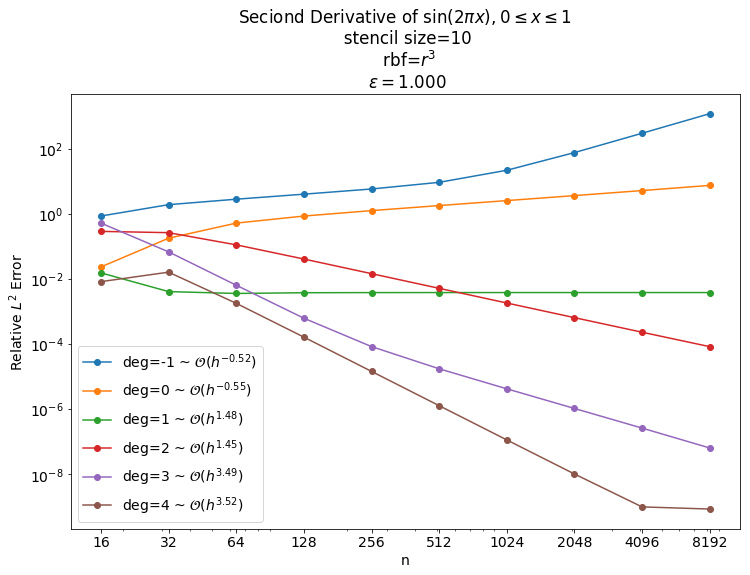

In [266]:
o_start, o_end = 2, 6
orders = []

name = rbf_label
if not rbf_obj['shape']:
    name = rbf_obj['tex']

plt.figure(figsize=(12,8))
for d, errors in zip(degs, all_errors):
    plt.loglog(ns, errors, 'o-')
    order = linreg(-np.log(ns[o_start:o_end]), np.log(errors[o_start:o_end]))[0]
    legend += ['deg=%d ~ $\mathcal{O}(h^{%.2f})$' % (d, order)]
plt.legend(legend)
plt.xlabel('n')
plt.xticks(ns, ns)
plt.ylabel('Relative $L^2$ Error')
plt.title('Seciond Derivative of $\\sin(2\\pi x), 0 \leq x \leq 1$ \n  stencil size=%d \n  rbf=%s \n $\\varepsilon=%.3f$' % (k,name, eps))
plt.show()

In [286]:
ns = [16 * 2**i for i in range(10)];   print('ns =', ns)
k = 10
d = 4
rbf_label = 'gaussian'


rbf_obj = rbf_dict[rbf_label]
rbf = rbf_obj['rbf']

# find epsilon on finest nodeset
if rbf_obj['shape']:
    xs = np.linspace(a,b, ns[-1])
    i = ns[-1]//2
    d = degs[-1]
    center = xs[i]
    stencil = xs[i - k//2 : i+(k+1)//2] - center
    scale_factor = np.max(np.abs(stencil))
    stencil /= scale_factor
    dist_mat = np.abs(np.subtract.outer(stencil, stencil))
    P = np.power.outer(stencil, np.arange(d+1))

    eps_best = optimize_eps(rbf, dist_mat, P=P)

    AP = np.block([[rbf(dist_mat, eps_best), P],[P.T, np.zeros((d+1, d+1))]])
    print('best epsilon = %.2f' % eps_best)
    print(np.log(la.cond(AP))/np.log(10))
else:
    eps_best = 1

epsilons = [eps_best* .8**i for i in range(-5, 6)]

all_errors = all_errors = [ [] for eps in epsilons]

for n in ns:
    xs = np.linspace(a,b, n, endpoint=True)
    Lfs = d2foo(xs)
    for eps_index, eps in enumerate(epsilons):
        W = fd_approx(xs, rbf_obj, eps, stencil_size=k, deg=d, optimize_shape=False)
        us = W @ foo(xs)
        err = la.norm(us - Lfs)/la.norm(Lfs)
        all_errors[eps_index].append(err)

ns = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
best epsilon = 0.73
12.000003190357788


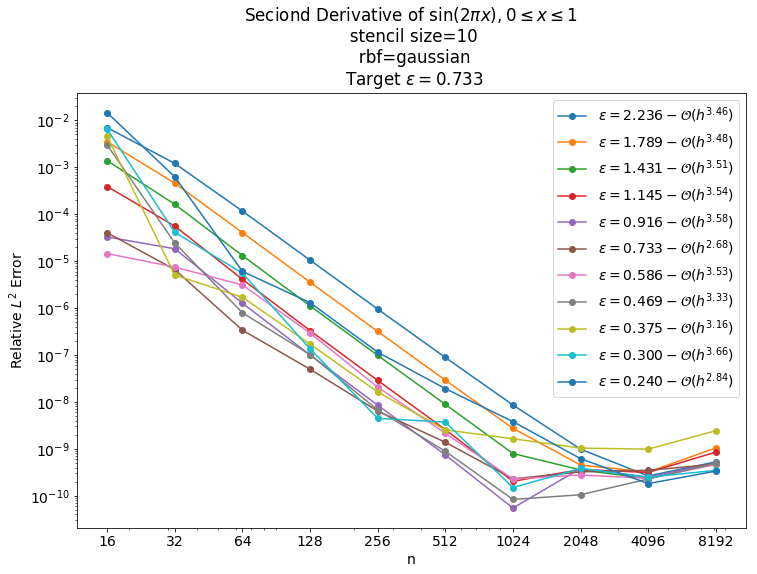

In [287]:
o_start, o_end = 2, 6
orders = []

name = rbf_label
if not rbf_obj['shape']:
    name = rbf_obj['tex']
    
legend = []

plt.figure(figsize=(12,8))
for eps, errors in zip(epsilons, all_errors):
    plt.loglog(ns, errors, 'o-')
    order = linreg(-np.log(ns[o_start:o_end]), np.log(errors[o_start:o_end]))[0]
    legend += ['$\\varepsilon=%.3f - \\mathcal{O}(h^{%.2f})$' % (eps, order)]
plt.legend(legend)
plt.xlabel('n')
plt.xticks(ns, ns)
plt.ylabel('Relative $L^2$ Error')
plt.title('Seciond Derivative of $\\sin(2\\pi x), 0 \leq x \leq 1$ \n  stencil size=%d \n  rbf=%s \n Target $\\varepsilon=%.3f$' % (k,name, eps_best))
plt.show()

In [305]:
ns = [64 * 2**i for i in range(6)];   print('ns =', ns)
ks = [5 * 2**i for i in range(4)]; print(ks)
d = 4
rbf_label = 'multiquadric'


rbf_obj = rbf_dict[rbf_label]
rbf = rbf_obj['rbf']

# find epsilon on finest nodeset
if rbf_obj['shape']:
    xs = np.linspace(a,b, ns[-1])
    i = ns[-1]//2
    k = ks[-1]
    center = xs[i]
    stencil = xs[i - k//2 : i+(k+1)//2] - center
    scale_factor = np.max(np.abs(stencil))
    stencil /= scale_factor
    dist_mat = np.abs(np.subtract.outer(stencil, stencil))
    P = np.power.outer(stencil, np.arange(d+1))

    eps = optimize_eps(rbf, dist_mat, P=P)

    AP = np.block([[rbf(dist_mat, eps), P],[P.T, np.zeros((d+1, d+1))]])
    print('epsilon = %.2f' % eps)
    print(np.log(la.cond(AP))/np.log(10))
else:
    eps = 1

all_errors = all_errors = [ [] for d in ks]

for n in ns:
    print('starting n=%d' % n)
    xs = np.linspace(a,b, n, endpoint=True)
    Lfs = d2foo(xs)
    for k_index, k in enumerate(ks):
        W = fd_approx(xs, rbf_obj, eps, stencil_size=k, deg=d, optimize_shape=False)
        us = W @ foo(xs)
        err = la.norm(us - Lfs)/la.norm(Lfs)
        all_errors[k_index].append(err)


ns = [64, 128, 256, 512, 1024, 2048]
[5, 10, 20, 40]
epsilon = 2.82
11.999998957492556
starting n=64
starting n=128
starting n=256
starting n=512
starting n=1024
starting n=2048


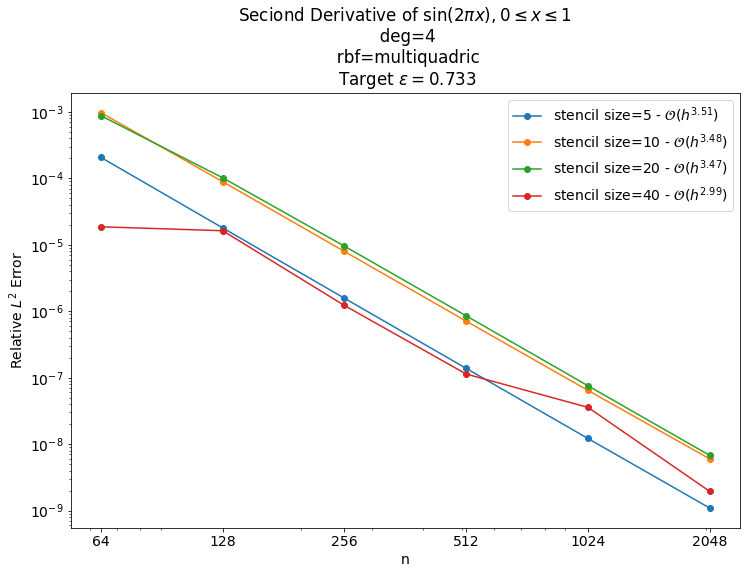

In [306]:
o_start, o_end = 1, 5
orders = []

name = rbf_label
if not rbf_obj['shape']:
    name = rbf_obj['tex']
    
legend = []

plt.figure(figsize=(12,8))
for k, errors in zip(ks, all_errors):
    plt.loglog(ns, errors, 'o-')
    order = linreg(-np.log(ns[o_start:o_end]), np.log(errors[o_start:o_end]))[0]
    legend += ['stencil size=%d - $\\mathcal{O}(h^{%.2f})$' % (k, order)]
plt.legend(legend)
plt.xlabel('n')
plt.xticks(ns, ns)
plt.ylabel('Relative $L^2$ Error')
plt.title('Seciond Derivative of $\\sin(2\\pi x), 0 \leq x \leq 1$ \n  deg=%d \n  rbf=%s \n Target $\\varepsilon=%.3f$' % (d,name, eps_best))
plt.show()